# 10.3: Evaluating and Interpreting Models

> ⚠️ **Work in Progress**
>
> This notebook is under active development and may change without notice.
> Content is not yet part of the published course narrative.


<div class="alert alert-block alert-warning">
<h1>Learning Objectives</h1>

<strong>Purpose</strong>  
Introduce students to the manual construction of a supervised classification
model using Naïve Bayes, emphasizing how data preparation, feature selection,
and training decisions affect model behavior and evaluation.

<strong>Students Learn</strong>
<ul>
  <li>Define a fixed feature space by removing invariant fingerprint bits and preserving the feature mask.</li>
  <li>Create, save, and reload stratified training and test splits along with supporting metadata.</li>
  <li>Diagnose class imbalance in a training dataset and apply downsampling as a model-specific preprocessing step.</li>
  <li>Build a probabilistic Naïve Bayes classifier from training data.</li>
  <li>Generate and interpret confusion matrices for classification-based inference.</li>
  <li>Generate and interpret ROC curves for probability-based model evaluation.</li>
</ul>

<strong>Core Activities</strong>
<ul>
  <li>Organize model inputs, splits, and metadata into a reproducible directory structure.</li>
  <li>Construct a Naïve Bayes classifier step-by-step using saved training data.</li>
  <li>Evaluate model performance using both class predictions and predicted probabilities.</li>
</ul>

<strong>Prior Knowledge</strong>
<ul>
  <li>Complete Module 10.1: <a href="content/modules/10_SupervisedML/10_1_data_prep.html">Data Preparation and Feature Engineering</a></li>
  <li>Complete Appendix A10.2: <a href="https://rebelford.github.io/2026Cheminformatics/content/appendices/App_10/A_10-2NaiveBayes.html">Bayes' Theorem: From Inference to Models</a></li>
</ul>

</div>


<div class="alert alert-block alert-info">
    


This chapter is built on <strong><a href="https://rebelford.github.io/2026Cheminformatics/content/modules/10_SupervisedML/10_2_NB_model_construction_workflow.html">10.2 Naive Bayes and Model Construction</a></strong> and we will start by reloading the predictions and the model, without refiting anything. Our goal is to use the data set of the previous chapter to understand:
  <ul>
      <li>confusion matrix anatomy and metrics</li>
      <li>class imbalance effects</li>
      <li>ROC curves</li>
      <li>Threshold movement and Youden index</li>
      <li>False Positives vs. False Negatives</li>
  </ul>
In this activity we will look at three different sets of data, the training set, the test set, and the entire set.
</div>


## What Evaluation Means?

Supervised learning produces a trained model, but training alone does not tell us how that model behaves when it is used. Model evaluation is the process of examining how a trained model makes decisions, what kinds of mistakes it makes, and how those mistakes change under different conditions. At its core, evaluation answers a different question than training:

* **Training asks:** *Did the model learn patterns from the data?*
* **Evaluation asks:** *What happens when the model is asked to decide?*

Most supervised classification models do not directly produce decisions. Instead, they produce scores, often expressed as probabilities, that reflect how strongly the model associates an input with each class. A decision is made only after those scores are compared to a threshold. This relationship underlies all evaluation:

* **Scores** quantify the model’s output based on learned statistical parameters  
* **Thresholds** define how scores are converted into class labels  
* **Decisions** reflect the outcome of applying a threshold to model scores  

In scikit-learn, calling `.predict()` produces a prediction by making a decision rather than returning a raw model score. This is done by applying an implicit threshold to the model’s internal outputs to identify the most probable class a sample belongs to. Model evaluation examines how these decisions behave across datasets, metrics, and thresholds, rather than treating predictions as fixed or final. The insights gained from evaluation guide subsequent choices about model design and use.


# 1. Reconstructing the Model (Reproducibility Checkpoint)

In this notebook, we regenerate the trained classifier from Module 10.2 so that it can be evaluated in a clean, reproducible environment. Regenerating does *not* mean discovering a new model; it means reconstructing the same trained model behavior using the same data products and design decisions. This section outlines the conceptual steps required to place a trained classifier back into active memory.

By the end of this process, we will have:
- A classifier object in memory that behaves identically to the model trained in Module 10.2
- Access to both predictions and probabilities for evaluation (`.predict()` and `.predict_proba()`)

Before loading anything, we must be explicit about *what kind* of regeneration we are performing. In this notebook, we assume:
- No new molecules are being introduced
- No new feature engineering is being performed
- No preprocessing or filtering decisions are being changed

In Module 10.4: Pipelines and Inference, we will cover a more robust and generalizable approach to model reconstruction. For now, our goal is to evaluate classifier behavior using the same processed data products created earlier.

To regenerate the classifier, we load the train/test data products saved during Module 10.2. These are located in the splits directory and include:
- Training feature arrays
- Test feature arrays
- Training labels
- Test labels

These arrays already reflect:
- Fingerprint generation (e.g., MACCS)
- Removal of invariant features
- Any class balancing or filtering decisions
- Consistent feature ordering

Because these transformations have already been applied, the original CSV feature table is not reloaded at this stage. The classifier is reconstructed using the same preprocessed feature arrays produced in Module 10.2, ensuring that its behavior matches the previously trained model. Workflows involving new data or regenerated features are deferred to the pipeline discussion. Here, our focus is on understanding and evaluating the outputs of .predict() and .predict_proba() for the model reconstructed from the Module 10.2 outputs.

## 1.1 Regenerate the Model

1. Load *.npy arrays generated in **[10.2](https://rebelford.github.io/2026Cheminformatics/content/modules/10_SupervisedML/10_2_NB_model_construction_workflow.html#save-the-test-train-split-as-np-arrays)** (train and test label vectors and feature matrices into memory)
2. Balance training set
3. Create classifier object (`clf_NB = BernoulliNB()`)
4. Train the model (fit the classifier

In [1]:
# Imports and paths
from pathlib import Path
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

SPLIT_ROOT = Path("data/AID743139/splits/90_10/arrays")

# 1. Load saved feature arrays and labels
X_train = np.load(SPLIT_ROOT / "X_train.npy")
X_test  = np.load(SPLIT_ROOT / "X_test.npy")
y_train = np.load(SPLIT_ROOT / "y_train.npy")
y_test  = np.load(SPLIT_ROOT / "y_test.npy")

# 2. Balance the training set (downsample inactives)
idx_inactives = np.where(y_train == 0)[0]
idx_actives   = np.where(y_train == 1)[0]

np.random.seed(0)
idx_inactives_down = np.random.choice(
    idx_inactives,
    size=len(idx_actives),
    replace=False
)

X_train_bal = np.vstack((
    X_train[idx_inactives_down],
    X_train[idx_actives]
))

y_train_bal = np.hstack((
    y_train[idx_inactives_down],
    y_train[idx_actives]
))

#3. Train classifier

clf_NB = BernoulliNB()
clf_NB.fit(X_train_bal, y_train_bal)
clf_NB

,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


The following cell regenerates the same evaluation artifacts produced during model construction (10.2) to verify that the classifier has been reconstructed correctly.  It should return a matrix of `[[400 206][ 25  49]]` and a ROC of 0.728.

Test-set Confusion Matrix
[[400 206]
 [ 25  49]]

ROC AUC: 0.728


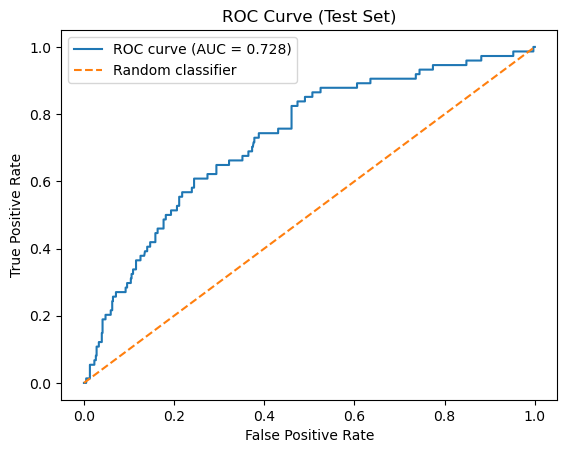

In [2]:
# --------------------------------------------------
# Regenerate evaluation artifacts (reproducibility check)
# --------------------------------------------------

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Classification-based predictions (implicit threshold)
y_test_pred = clf_NB.predict(X_test)

# Confusion matrix
CM = confusion_matrix(y_test, y_test_pred)
TN, FP, FN, TP = CM.ravel()

print("Test-set Confusion Matrix")
print(CM)

# 2. Probability-based outputs (scores)
y_test_proba = clf_NB.predict_proba(X_test)[:, 1]

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

print(f"\nROC AUC: {roc_auc:.3f}")

# 3. Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.show()


# 2. Classification Based Evaluation (`.predict()`)
There is no single number that fully describes how a classifier performs. Instead of immediately collapsing model behavior into a summary statistic, we begin by examining the confusion matrix, which records how predictions are distributed across correct and incorrect outcomes. By separating true positives, false positives, true negatives, and false negatives, the confusion matrix makes explicit which types of mistakes the model makes and how often they occur. This structured view provides the foundation for all subsequent evaluation metrics.

>*Historically, the confusion matrix is so named because it explicitly shows where a model “confuses” one class for another, rather than hiding those errors inside a single summary value.* Simply speaking, a False positive was when the model thought  an inactive compound was active, and a false negative is when the model predicts an active compound is inactive.

In the sections that follow, we will use the confusion matrix to derive quantitative evaluation measures. Each metric is computed directly from these counts, and their meaning is best understood only after the structure of the confusion matrix is clear.

In this class we will use the scikit-learn convention above, where labels are sorted $[0,1]$ and align with binary encoding 0 (inactive) and 1 (active). 

<div style="font-family: Arial, sans-serif; margin-top: 20px;">
<center>
  Confusion Matrix (scikit-learn Convention)
  <table border="1" cellspacing="0" cellpadding="10" style="border-collapse: collapse; text-align: center;">
    <tr>
      <th rowspan="2">Actual</th>
      <th colspan="2">Predicted</th>
    </tr>
    <tr>
      <th>0</th>
      <th>1</th>
    </tr>
    <tr>
      <th>0</th>
      <td>TN<br><small>True Negative</small></td>
      <td>FP<br><small>False Positive</small></td>
    </tr>
    <tr>
      <th>1</th>
      <td>FN<br><small>False Negative</small></td>
      <td>TP<br><small>True Positive</small></td>
    </tr>
  </table>
</center>
</div>


<div class="alert alert-block alert-info">
<strong>Check your understanding</strong>
<p>What do the rows of the Confusion Matrix stand for?
</p>


  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
The rows repesent the actual values, that is the first row represents the compounds that are inactive and the second represents the compounds that are active
</details>
</div>
<p>What do the columns represent?</p>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
<p>The Columns represent the Predicted values, the first column represents compounds predicted inactive and the second compounds predicted active</p>
</details>
</div>
<p>What does the diagonal represent?</p>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
<p>The diagonal represents the number of correct predictions, going from inactive to active</p>
</details>
</div>
<p>What does the off-diagonal represent?</p>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
The off-diagonal represents the number of incorrect predictions
</details>
</div>
</div>



You need to be aware that there is an alternate convention that starts with the positive $[1,0]$ type ordering.

<div class="alert alert-block alert-success"> 
<strong>Alternate Convention:</strong> Important: There is no single universal visual convention for confusion matrices. Different fields and textbooks place the “positive” and “negative” classes in different positions. What matters is being explicit and consistent. In this notebook, we follow the scikit-learn convention used by confusion_matrix(y_true, y_pred): 
  <ul>
      <li>Rows corresond to true (actual) labels</li>
      <li>Columns correspond to predicted labels</li>
      <li>Class <code>0</code> appears before class <code>1</code></li>
  </ul>
    
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
<summary>Explanation</summary>
Many sources choose to place the positive class first and the negative class second, effectively reversing the row and column order relative to the scikit-learn default. This “positive-first” convention is shown below.
<div style="font-family: Arial, sans-serif; margin-top: 20px;">
<center>
  Confusion Matrix (Positive-First / Conceptual Convention)
  <table border="1" cellspacing="0" cellpadding="10" style="border-collapse: collapse; text-align: center;">
    <tr>
      <th rowspan="2">Actual</th>
      <th colspan="2">Predicted</th>
    </tr>
    <tr>
      <th>1</th>
      <th>0</th>
    </tr>
    <tr>
      <th>1</th>
      <td>TP<br><small>True Positive</small></td>
      <td>FN<br><small>False Negative</small></td>
    </tr>
    <tr>
      <th>0</th>
      <td>FP<br><small>False Positive</small></td>
      <td>TN<br><small>True Negative</small></td>
    </tr>
  </table>
</center>
</div>

We will not use this convention in this class. However, when comparing confusion matrices across sources, you must always verify which class appears first in the rows and columns, as reversing this order changes the interpretation of every cell.
</details>
</div>
</div>

Rather than immediately summarizing performance with numerical metrics, we begin by examining confusion matrices for the test, balanced training and full training sets.  Only the test set provides an unbiased estimate of real-world model performance. However, by comparing it to confusion matrices generated from the training data, we can better understand how class balance and data reuse influence the resulting metrics.

**Why three confusion matrices?**  
By examining these three confusion matrices side by side, we can separate the effects of model learning, class imbalance, and data leakage, and establish a clear foundation for the evaluation metrics introduced next.
- **Test set :** This matrix reflects model performance on previously unseen data and provides the most realistic estimate of how the model would behave in practice.
- **Balanced training set:**  This matrix shows how the classifier performs on the data distribution it was trained on. Because the classes were artificially balanced, this view helps isolate the model’s learned decision behavior without the influence of class imbalance.
- **Full training set:** This matrix illustrates how the trained classifier behaves when applied back to the original, imbalanced training data. Comparing this to the balanced-training confusion matrix highlights the impact of class prevalence on evaluation.

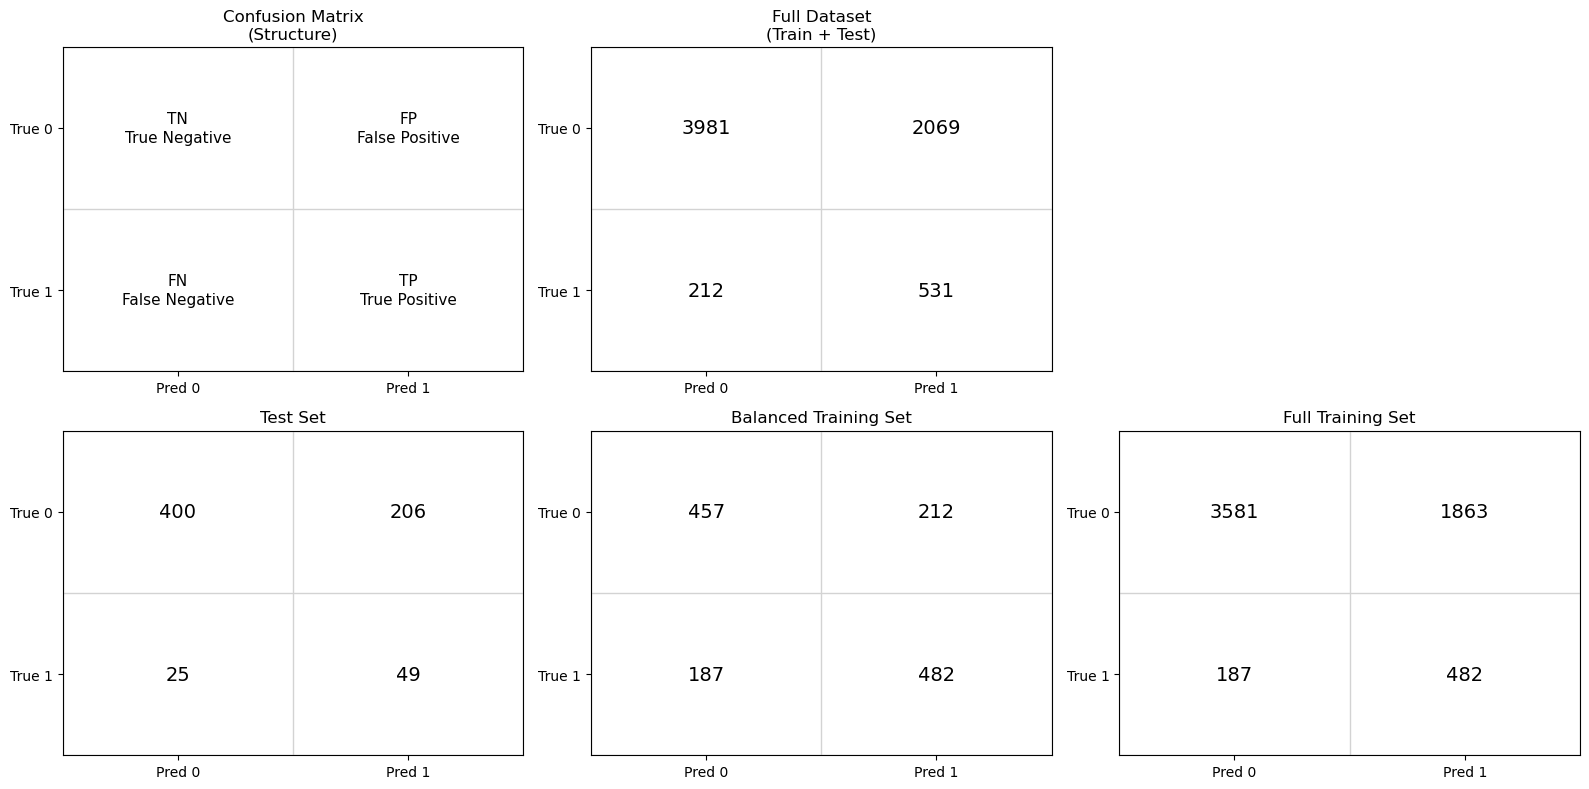

Class balance by dataset
------------------------------------------------------------------------------------------
Full dataset (original)   | Inactive (0):  6050 | Active (1):   743 | Ratio (0:1):   8.14
Training set              | Inactive (0):  5444 | Active (1):   669 | Ratio (0:1):   8.14
Test set                  | Inactive (0):   606 | Active (1):    74 | Ratio (0:1):   8.19
Balanced training set     | Inactive (0):   669 | Active (1):   669 | Ratio (0:1):   1.00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Create full data set
X_full = np.vstack((X_train, X_test))
y_full = np.hstack((y_train, y_test))

# -------------------------------------------------
# Generate predictions
# -------------------------------------------------
y_test_pred       = clf_NB.predict(X_test)
y_train_bal_pred  = clf_NB.predict(X_train_bal)
y_train_pred      = clf_NB.predict(X_train)
y_full_pred = clf_NB.predict(X_full)

# -------------------------------------------------
# Confusion matrices
# -------------------------------------------------
cm_test      = confusion_matrix(y_test, y_test_pred)
cm_train_bal = confusion_matrix(y_train_bal, y_train_bal_pred)
cm_train     = confusion_matrix(y_train, y_train_pred)
cm_full = confusion_matrix(y_full, y_full_pred)

cms = [None, cm_test, cm_train_bal, cm_train, cm_full]

titles = [
    "Confusion Matrix\n(Structure)",
    "Test Set",
    "Balanced Training Set",
    "Full Training Set",
    "Full Dataset\n(Train + Test)"
]


# Labels for structural matrix
structure_labels = {
    (0, 0): "TN\nTrue Negative",
    (0, 1): "FP\nFalse Positive",
    (1, 0): "FN\nFalse Negative",
    (1, 1): "TP\nTrue Positive",
}


# -------------------------------------------------
# Arrange confusion matrices by row
# -------------------------------------------------
row1 = [
    (None, "Confusion Matrix\n(Structure)"),
    (cm_full, "Full Dataset\n(Train + Test)")
]

row2 = [
    (cm_test, "Test Set"),
    (cm_train_bal, "Balanced Training Set"),
    (cm_train, "Full Training Set")
]

# Labels for structural matrix
structure_labels = {
    (0, 0): "TN\nTrue Negative",
    (0, 1): "FP\nFalse Positive",
    (1, 0): "FN\nFalse Negative",
    (1, 1): "TP\nTrue Positive",
}

# -------------------------------------------------
# Plot
# -------------------------------------------------
fig = plt.figure(figsize=(16, 8))

# ---- Row 1 ----
for idx, (cm, title) in enumerate(row1, start=1):
    ax = plt.subplot(2, 3, idx)
    ax.set_title(title)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

    for i in range(3):
        ax.axhline(i - 0.5, color="lightgray", linewidth=1)
        ax.axvline(i - 0.5, color="lightgray", linewidth=1)

    if cm is None:
        for (i, j), label in structure_labels.items():
            ax.text(j, i, label, ha="center", va="center",
                    fontsize=11, linespacing=1.3)
    else:
        for i in range(2):
            for j in range(2):
                ax.text(j, i, cm[i, j], ha="center", va="center",
                        fontsize=14)

    ax.set_facecolor("white")

# ---- Row 2 ----
for idx, (cm, title) in enumerate(row2, start=4):
    ax = plt.subplot(2, 3, idx)
    ax.set_title(title)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

    for i in range(3):
        ax.axhline(i - 0.5, color="lightgray", linewidth=1)
        ax.axvline(i - 0.5, color="lightgray", linewidth=1)

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    fontsize=14)

    ax.set_facecolor("white")

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Class balance summary
# -------------------------------------------------
def print_class_balance(name, y):
    n_inactive = np.sum(y == 0)
    n_active   = np.sum(y == 1)
    ratio = n_inactive / n_active if n_active != 0 else np.inf

    print(
        f"{name:25s} | "
        f"Inactive (0): {n_inactive:5d} | "
        f"Active (1): {n_active:5d} | "
        f"Ratio (0:1): {ratio:6.2f}"
    )

# Reconstruct full dataset labels (pre-split)
y_full = np.hstack((y_train, y_test))

print("Class balance by dataset")
print("-" * 90)
print_class_balance("Full dataset (original)", y_full)
print_class_balance("Training set", y_train)
print_class_balance("Test set", y_test)
print_class_balance("Balanced training set", y_train_bal)


<div class="alert alert-block alert-info">
<strong>Check your understanding</strong>
<br>
<p>1. Why do the training set and test set have the same inactive-to-active ratio as the full dataset, while the balanced training set does not? 
</p>
<p><strong>Hint:</strong>  Review <a href="https://rebelford.github.io/2026Cheminformatics/content/modules/10_SupervisedML/10_2_NB_model_construction_workflow.html#train-test-split-a-9-1-ratio"> module 10.2 section 1.5 Train-Test_Split</a></p>


  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
The <code>stratify=y</code> parameter setting ensured the test and training sets had the same active/inactive ratio as the original dataset. We then created the balanced training set by downsampling the inactives of the training set so that the number of inactives equaled the number of actives.
</details>
</div>
<br>
<p>2. In the test set, the model predicts 425 compounds as inactive, and 400 of those predictions are correct. In contrast, it predicts 255 compounds as active, but only 49 of those predictions are correct. Why does the model appear very reliable when predicting inactives, but unreliable when predicting actives?</p>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
This illustrates the effect of class prevalence on the reliability of model predictions. Although the classifier was trained on a balanced dataset and did not learn to favor one class over the other, it is evaluated on a test set where inactive compounds greatly outnumber active compounds.

Because inactive compounds are common, most predictions of “inactive” are correct. In contrast, active compounds are rare, so when the model predicts “active,” it is far more likely to be wrong than right. As a result, predictions of “active” are unreliable, even though the model makes many such predictions.

This asymmetry does not arise from bias learned during training. It arises because class prevalence affects how trustworthy predictions are. This motivates the need for a metric that directly answers the question: when the model predicts a compound as active, how often is that prediction correct?

</details>
</div>
<br>
<p>3. The confusion matrix for the balanced training set shows that the classifier correctly predicts roughly 70% of both active and inactive compounds. Why should this result not be interpreted as an estimate of real-world model performance, and why is it still useful to examine? </p>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
The balanced training set confusion matrix shows that the classifier makes roughly similar types of errors for actives and inactives, correctly classifying about 70% of each. However, this result does not represent real predictive performance, because these data were used to fit the model. Instead, it reflects how well the model fits the training distribution and whether it treats the two classes symmetrically.

When the same model is applied to the test set, the confusion matrix changes substantially. The test set reflects the original class imbalance, where active compounds are rare. As a result, errors affecting the minority class dominate the interpretation, and predictions of “active” become unreliable.

This contrast illustrates the distinction between fitting and generalization. Performance on the training data reflects how well the model has learned patterns under controlled conditions, specifically, a balanced class distribution where both actives and inactives are equally represented. In this setting, the confusion matrix reveals whether the model treats the two classes symmetrically and whether it can separate them at all under idealized conditions.

Test-set performance, in contrast, evaluates how those learned patterns behave when the model is applied to unseen data drawn from the original, imbalanced population. Here, the same model must operate under realistic class prevalence, where active compounds are rare. The resulting confusion matrix therefore reflects not only what the model has learned, but how useful that learning is when confronted with the data conditions it would encounter in practice.
</details>
</div>
<br>
<p>4. Why are the number of actual active compounds (FN and TP) the same in the balanced training and full training set?  That is for both, FN=187 and TP=482.
</p>
<p><strong>Hint:</strong>  Review <a href="https://rebelford.github.io/2026Cheminformatics/content/modules/10_SupervisedML/10_2_NB_model_construction_workflow.html#train-test-split-a-9-1-ratio"> module 10.2 section 1.5 Train-Test_Split</a></p>


  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
If you look at <a href="https://rebelford.github.io/2026Cheminformatics/content/modules/10_SupervisedML/10_2_NB_model_construction_workflow.html#balance-the-training-set-by-downsampling"> module 10.2 section 2.3 Balance the Training Set by Downsampling</a>, you will see that we set the number of inactives in the balanced training set to equal the number of actives present in the training data (669), and so these not only represent the same number of molecules, but the exact same molecules.
</details>
</div>
<br>
<p>5. If you were only told the total number of correct predictions made by this model, what important information would you be missing? Use the confusion matrix to explain why a single summary number is not sufficient.</p>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
A single summary number, such as the total number of correct predictions, does not reveal which compounds are being classified correctly or incorrectly. The confusion matrix shows that correct predictions are not evenly distributed across classes.

In the test set, most correct predictions come from correctly identifying inactive compounds, while a large fraction of active compounds are misclassified. If we only looked at the total number of correct predictions, the model might appear to perform reasonably well, even though it is failing to identify most active compounds.

The confusion matrix separates correct and incorrect predictions by class and distinguishes different types of error. This allows us to distinguish between mistakes that involve falsely labeling a compound as active and mistakes that involve missing an active compound entirely. These distinctions are essential in scientific and regulatory contexts, where different errors have very different consequences.

This motivates the need for multiple evaluation metrics, each designed to quantify a different aspect of model behavior using the four values in the confusion matrix: true positives, true negatives, false positives, and false negatives.
</details>
</div>
</div>

The confusion matrix provides the raw information needed to evaluate a classifier, but it does not reduce that information to a single interpretable quantity. In the next section, we introduce evaluation metrics that summarize different aspects of model behavior using the four entries of the confusion matrix.

## 2.1 Confusion Matrix Based Evaluation Metrics
The confusion matrix reveals which kinds of mistakes the model makes.

|                     | **Predicted Inactive**  | **Predicted Active**    |
| ------------------- | ----------------------- | ----------------------- |
| **Actual Inactive** | **TN** (True Negative)  | **FP** (False Positive) |
| **Actual Active**   | **FN** (False Negative) | **TP** (True Positive)  |  



## 2.2 Table of Confusion Matrix Metrics
All the metrics below are derived from TN, TP, FN & FP and summarize the model's validity (mistakes) from different scientific perspectives.
| Metric                   | Mathematical Definition                                                                                    | What This Metric Tells Us                                                             |
| ------------------------ | ---------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------- |
| **Accuracy**             | $\displaystyle \frac{TP + TN}{TP + TN + FP + FN}$                                                          | What fraction of all predictions—active and inactive—were correct overall.            |
| **Precision**            | $\displaystyle \frac{TP}{TP + FP}$                                                                         | When the model predicts “active,” how often is it actually correct?                   |
| **Sensitivity (Recall)** | $\displaystyle \frac{TP}{TP + FN}$                                                                         | Of all truly active compounds, how many did the model successfully identify?          |
| **Specificity**          | $\displaystyle \frac{TN}{TN + FP}$                                                                         | Of all truly inactive compounds, how many did the model correctly reject?             |
| **Balanced Accuracy**    | $\displaystyle \frac{\text{Sensitivity} + \text{Specificity}}{2}$                                          | How well the model performs across both classes, even when the dataset is imbalanced. |
| **F1 Score**             | $\displaystyle \frac{2,(\text{Precision}\times\text{Sensitivity})}{\text{Precision} + \text{Sensitivity}}$ | A single score that balances finding actives with avoiding false positives.           |

**Quick Rules of Thumb:**
- If accuracy is high but balanced accuracy is low → suspect class imbalance.
- Use balanced accuracy when your dataset has a lot more inactives than actives.
- Sensitivity is important when missing an active could be costly (e.g., in drug screening).
- Specificity is important when false positives are costly (e.g., expensive follow-up experiments).
- AUC-ROC gives a broader view of model quality — useful even when you're not picking a classification threshold yet.

## 2.3. Confusion Matrix Based Evaluation Metrics
To answer the question “Is the model good enough?”, we rely on key metrics calculated from the confusion matrix:

### 2.3.1 Accuracy
<div class="alert alert-block alert-success"> 
<p>
<center>
    <strong>Accuracy: The fraction of total predictions that the model classified correctly.</strong></center>
</p>
\[ \frac{TP + TN}{TP + TN + FP + FN} \]

<div class="alert alert-block alert-info">
<details>
<summary>Explanation</summary>

**Definition**
Accuracy is defined as:

$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $

In words, accuracy is the number of correct predictions divided by the total number of predictions.

**Interpretation**

* An accuracy of 1.0 (100%) means the model made no classification errors.
* An accuracy of 0.5 (50%) for a binary classifier is equivalent to random guessing *if* the classes are balanced.
* Accuracy treats false positives and false negatives equally, which is not always desirable depending on the application.

**When Accuracy Works Well**
Accuracy is most informative when:  
* The dataset is balanced (roughly equal numbers of positive and negative samples).
* The cost of false positives and false negatives is similar.

**When Accuracy Can Be Misleading**  
Accuracy can give a false sense of model quality when:

* The classes are highly imbalanced.
* One type of error (FP or FN) is much more costly than the other.

For example, in a dataset where 95% of compounds are inactive, a model that predicts *everything* as inactive will achieve 95% accuracy—despite having no practical value for identifying active compounds.
</details>
</div>
</div>


### 2.3.2 Precision
<div class="alert alert-block alert-success"> 
<p>
<center><strong>Precision: When the model predicts a compound is active, how often is that prediction correct? </strong></center>
</p>    
\[ \frac{TP}{TP + FP}  \]

<div class="alert alert-block alert-info">
<details>
<summary>Explanation</summary>
    
**Definition**  
Precision is defined as:

$ \text{Precision} = \frac{TP}{TP + FP} $

In words, precision is the number of correctly predicted positives divided by the total number of positive predictions made by the model.

**Interpretation**

* A precision of 1.0 (100%) means that every compound predicted as active truly is active.
* A lower precision indicates that many predicted actives are actually inactive (false positives).
* Precision focuses *only* on positive predictions and ignores true negatives.

**Why Precision Matters**

Precision is especially important when the cost of false positives is high. In cheminformatics, a false positive corresponds to an inactive compound being predicted as active, which can lead to wasted experimental effort, time, and resources.

**When Precision Is the Right Metric**

Precision is most informative when:  
* You care more about the *quality* of predicted positives than the total number found.  
* False positives are more costly than false negatives.  
* You want high confidence that predicted actives are truly active.

**Trade-off with Recall**

Precision is often in tension with recall. A model can achieve high precision by being very conservative and predicting “active” only when it is very confident, but this may cause it to miss many true actives (low recall). Understanding this trade-off is essential when evaluating classification models.
</details>
</div>
</div>

### 2.3.3 Sensitivity (Recall / True Positive Rate)
<div class="alert alert-block alert-success"> 
<p><center><strong>Sensitivity: Of all the truly active compounds, how many did the model successfully detect?</strong></center></p>

$$\frac{TP}{TP + FN}$$

<div class="alert alert-block alert-info">
<details>
<summary>Explanation</summary>
    
**Definition**  

$ \text{Sensitivity} = \frac{TP}{TP + FN} $

In words, sensitivity is the fraction of true positives that the model correctly identifies.

**Interpretation**

* A sensitivity of 1.0 (100%) means the model found *all* active compounds.
* A low sensitivity indicates that many active compounds were missed (false negatives).
* Sensitivity ignores false positives entirely and focuses only on how well positives are recovered.

**Why Sensitivity Matters**

Sensitivity is critical when missing a positive result is costly. In chemical screening, a false negative corresponds to an active compound being incorrectly classified as inactive, potentially causing a promising candidate to be discarded prematurely.

**When Sensitivity Is the Right Metric**

Sensitivity is most informative when:  
* You want to capture as many true actives as possible.  
* False negatives are more costly than false positives.  
* The goal is early-stage screening, where it is acceptable to tolerate some false positives in order to avoid missing real actives.

**Trade-off with Precision**

Sensitivity often trades off with precision. A model can achieve high sensitivity by predicting “active” more liberally, but this may increase the number of false positives and reduce precision. Balancing sensitivity and precision depends on the scientific and practical goals of the analysis.
</details>
</div>
</div>

### 2.3.4 Specificity (True Negative Rate)
<div class="alert alert-block alert-success"> 
<p><center><strong>Specificity: Of all the truly inactive compounds, how many did the model correctly classify as inactive?</strong></center></p>
    <br>
\[ \frac{TN}{TN + FP} \]

<div class="alert alert-block alert-info">
<details>
<summary>Explanation</summary
                        
**Definition**  

$ \text{Specificity} = \frac{TN}{TN + FP} $

In words, specificity is the fraction of true negatives that the model correctly identifies.

**Interpretation**

* A specificity of 1.0 (100%) means the model made no false-positive errors.
* A lower specificity indicates that many inactive compounds were incorrectly labeled as active.
* Specificity ignores false negatives and focuses exclusively on negative predictions.

**Why Specificity Matters**

Specificity is important when false positives are costly. In chemical screening, a false positive corresponds to an inactive compound being flagged as active, which can lead to unnecessary follow-up experiments, wasted reagents, and inefficient use of laboratory resources.

**When Specificity Is the Right Metric**

Specificity is most informative when:  
* You want to confidently rule out inactive compounds.  
* False positives are more costly than false negatives.  
* Later-stage screening or validation requires high confidence in negative classifications.

**Relationship to Sensitivity**

Specificity is complementary to sensitivity. Increasing sensitivity often decreases specificity, and vice versa. Together, sensitivity and specificity describe how well a model separates the positive and negative classes across the full dataset.

</details>
</div>
</div>

### 2.3.5 Balanced Accuracy
<div class="alert alert-block alert-success"> 
<p><center><strong>Balanced Accuracy: How well does the model perform on each class, on average?</strong></center></p>

\[ \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right) \]

<div class="alert alert-block alert-info">
<details>
<summary>Explanation</summary>

**Definition**  
Balanced accuracy is defined as the average of sensitivity (recall) and specificity:

$ \text{Balanced Accuracy} = \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right) $

Equivalently:

$ \text{Balanced Accuracy} = \frac{\text{Sensitivity} + \text{Specificity}}{2} $

**Interpretation**

* A balanced accuracy of 1.0 (100%) means the model perfectly classifies both actives and inactives.
* A balanced accuracy of 0.5 indicates performance no better than random guessing for a binary classifier.
* Balanced accuracy penalizes models that perform well on one class but poorly on the other.

**Why Balanced Accuracy Matters**

Balanced accuracy is particularly valuable when working with imbalanced datasets, which are common in cheminformatics and biological screening. It prevents a model from appearing artificially strong simply by predicting the majority class well.

For example, if most compounds are inactive, a model that predicts everything as inactive may achieve high standard accuracy—but its balanced accuracy will be low because sensitivity is poor.

**When Balanced Accuracy Is the Right Metric**

Balanced accuracy is most informative when:  
* The classes are imbalanced.  
* You want equal emphasis on detecting actives and correctly rejecting inactives.  
* You are comparing different models fairly across the same dataset.

</details>
</div>
</div>

### 2.3.6 F1 Score
<div class="alert alert-block alert-success"> 
<p><center><strong>The F1 score balances two different ways of judging model performance: how many real actives the model finds (recall), and how trustworthy its active predictions are (precision). It is high only when both are reasonably good.</strong></center></p>

$$2 \times \frac{\text{Precision} \times \text{Sensitivity}}{\text{Precision} + \text{Sensitivity}}$$

<div class="alert alert-block alert-info">
<details>
<summary>Explanation</summary>

**Definition**  
The F1 score is defined as the harmonic mean of precision and sensitivity (recall):

$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Sensitivity}}{\text{Precision} + \text{Sensitivity}} $

Substituting the confusion matrix terms:

$ \text{F1 Score} = \frac{2TP}{2TP + FP + FN} $

**Interpretation**

* An F1 score of 1.0 (100%) means the model has perfect precision and perfect sensitivity.
* A low F1 score indicates poor performance in either precision, sensitivity, or both.
* The F1 score does not consider true negatives and focuses entirely on the positive class.

**Why the F1 Score Matters**

The F1 score is valuable when you want a single metric that reflects a balance between:
* avoiding false positives (precision), and  
* avoiding false negatives (sensitivity).

In chemical screening, this is often desirable when neither missing active compounds nor pursuing too many inactive compounds is acceptable.

**When the F1 Score Is the Right Metric**

The F1 score is most informative when:  
* The dataset is imbalanced.  
* Both false positives and false negatives are costly.  
* You want a single number to compare models that trade off precision and sensitivity differently.

**Limitations of the F1 Score**

While useful, the F1 score has limitations:
* It ignores true negatives entirely.
* It does not distinguish between different types of errors beyond FP and FN.
* Two models with very different precision–recall trade-offs can have the same F1 score.

For these reasons, the F1 score should be interpreted alongside other metrics rather than used alone.
</details>
</div>
</div>

## 2.4 Interpreting Differences Between Training and Test Performance
When evaluating a supervised learning model, it is important to compare performance on the training set to performance on the test set. These two evaluations answer different questions:
   * Training set performance tells us how well the model learned patterns from the data it was trained on.
   * Test set performance tells us how well those learned patterns generalize to previously unseen data.

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix

def compute_metrics(y_true, y_pred):
    """
    Compute classification metrics derived from the confusion matrix.
    Returns a dictionary of metrics.
    """
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    accuracy  = accuracy_score(y_true, y_pred)
    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0   # sensitivity
    specificity = TN / (TN + FP) if (TN + FP) else 0.0
    balanced_accuracy = (recall + specificity) / 2
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity": recall,
        "Specificity": specificity,
        "Balanced Accuracy": balanced_accuracy,
        "F1 Score": f1,
    }


# -------------------------------------------------
# Compute metrics
# -------------------------------------------------
metrics_test = compute_metrics(y_test, y_test_pred)
metrics_train_bal = compute_metrics(y_train_bal, y_train_bal_pred)


# -------------------------------------------------
# Print results
# -------------------------------------------------
print("TEST SET PERFORMANCE")
for k, v in metrics_test.items():
    print(f"{k:18s} = {v:.4f}")

print("\nBALANCED TRAINING SET PERFORMANCE")
for k, v in metrics_train_bal.items():
    print(f"{k:18s} = {v:.4f}")


TEST SET PERFORMANCE
Accuracy           = 0.6603
Precision          = 0.1922
Sensitivity        = 0.6622
Specificity        = 0.6601
Balanced Accuracy  = 0.6611
F1 Score           = 0.2979

BALANCED TRAINING SET PERFORMANCE
Accuracy           = 0.7018
Precision          = 0.6945
Sensitivity        = 0.7205
Specificity        = 0.6831
Balanced Accuracy  = 0.7018
F1 Score           = 0.7073


This table compares performance on the training and test sets using multiple evaluation metrics. The goal is not to optimize any single number, but to understand how model behavior changes when applied to unseen data. Differences between training and test performance reveal how well the learned patterns generalize and which types of errors dominate.

| Metric                   | Training Set | Test Set | What We Learn                                                                                                                                                                        |
| ------------------------ | ------------ | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Accuracy**             | 0.702        | 0.660    | Training and test accuracy are similar, suggesting the model is not severely overfitting. The model has learned some real signal, but overall performance remains modest.            |
| **Precision**            | 0.695        | 0.192    | Precision collapses on the test set because the test data are highly imbalanced. Even a moderate false positive rate produces many false positives when inactive compounds dominate. |
| **Sensitivity (Recall)** | 0.721        | 0.662    | The model continues to identify a substantial fraction of true actives in unseen data, indicating that activity-related signal generalizes reasonably well.                          |
| **Specificity**          | 0.683        | 0.660    | Specificity remains similar between training and test sets, suggesting the model’s handling of inactive compounds is relatively stable.                                              |
| **Balanced Accuracy**    | 0.702        | 0.661    | Balanced accuracy remains well above random (0.5), indicating meaningful—but imperfect—separation of actives and inactives.                                                          |
| **F1 Score**             | 0.707        | 0.298    | The large drop reflects the combined effect of reasonable sensitivity but very low precision on the imbalanced test set, highlighting the cost of false positives.                   |

At first glance, these results may seem contradictory. Several metrics suggest that the model has learned meaningful structure and generalizes reasonably well, while others indicate very poor performance on the test set. In particular, the sharp decline in precision and F1 score stands in contrast to the relatively stable sensitivity, specificity, and balanced accuracy. To understand why these metrics behave so differently, and what that tells us about the model, we need to take a closer look at how class imbalance and decision thresholds affect evaluation.

<div class="alert alert-block alert-info">
<strong>Deep Dive:</strong> Why Do Precision and F1 Collapse on the Test Set?
<br>
<div class ="alert-block alert-success">
<details>
<summary>Explanation</summary>
<br>
<p>The dramatic drop in precision and F1 score on the test set is not primarily a failure of the model, it is a consequence of class imbalance.</p>

<p><strong>Precision</strong> answers the question: <em> Of the compounds predicted to be active, how many truly are active?”</em> In an imbalanced dataset, inactive compounds vastly outnumber actives. As a result, even a modest false positive rate can generate many false positives, overwhelming the true positives and driving precision downward.</p>

<p><strong>F1 score</strong> combines precision and sensitivity into a single metric. Because precision is very low on the test set, the F1 score also collapses, even though sensitivity remains reasonably high.</p>

<p>Importantly, this does <em>not</em> mean the model cannot detect actives. It means that, at the chosen decision threshold, many inactive compounds are incorrectly labeled as active. This distinction is critical: sensitivity and specificity describe class-conditional behavior, while precision depends strongly on class prevalence. This is why confusion-matrix-based metrics must be interpreted alongside dataset balance, and why a ranking-based evaluation (ROC–AUC) is a necessary next step.</p>
</details>
</div>
</div>


2.4.1 Interpreting Metric Disagreements and the Role of Decision Thresholds

At first glance, the results in the table above may appear contradictory. Several metrics, such as sensitivity, specificity, and balanced accuracy, suggest that the model has learned meaningful structure and generalizes reasonably well to unseen data. At the same time, precision and F1 score collapse dramatically on the test set, indicating very poor performance.

This apparent contradiction arises because different metrics answer different questions, and some of those questions depend strongly on class prevalence and on how model scores are converted into class labels.

Precision asks: Of the compounds predicted to be active, how many truly are active? In the imbalanced test set, inactive compounds vastly outnumber actives. As a result, even a modest false positive rate produces many false positives, overwhelming the relatively small number of true positives and driving precision downward. Because the F1 score combines precision and sensitivity, it also collapses—even though sensitivity remains reasonably high.

Importantly, this does not mean the model cannot detect actives. Sensitivity shows that a substantial fraction of true actives are still being identified. Instead, the problem lies in how the model’s scores are translated into class labels at the chosen decision threshold. At this cutoff, many inactive compounds are labeled as active, making positive predictions unreliable.

Many classifiers do not directly decide whether a compound is active or inactive. Instead, they assign a score indicating how strongly a compound resembles known actives. A decision threshold is the cutoff used to convert that score into a discrete label. Compounds with scores above the threshold are labeled “active,” while those below the threshold are labeled “inactive.” Changing the threshold does not alter the model or the data, it changes only how predictions are turned into labels, and therefore which outcomes are counted as true positives, false positives, true negatives, and false negatives.

This distinction is critical. Metrics such as sensitivity and specificity describe class-conditional behavior, while precision and F1 depend strongly on both class prevalence and the decision threshold. All confusion-matrix-based metrics therefore describe model performance at one specific cutoff.

The key takeaway is that a model may contain useful discriminatory information while still appearing unreliable at a particular threshold. Before deciding whether a model is truly useful, we need a way to evaluate its ability to separate actives from inactives independently of any single decision threshold.

This motivates a shift from classification-based evaluation to ranking-based evaluation, where we ask not “Is this compound classified as active?” but rather “Does the model assign higher scores to actives than to inactives across all possible thresholds?” In the next section, we introduce ROC curves and the ROC–AUC metric to answer exactly this question.

# 3. Under the Hood: Confusion Matrices, Thresholds and Probability Scores
Up to this point, we have evaluated our model using confusion matrices derived from `.predict()`. This is a natural starting point: confusion matrices provide an explicit, interpretable summary of how a binary classifier performs at a particular decision rule.

However, `.predict()` represents only the final step in the model’s reasoning. Internally, the classifier does not begin by assigning class labels (active or inactive). Instead, it computes a continuous probability score (0 to 1) for each compound that reflects how strongly it resembles known actives relative to inactives.

The method `.predict_proba()` exposes these scores directly. For a binary classifier, it produces one probability estimate per compound indicating the model’s confidence that the compound belongs to the active class. A decision threshold is then used to convert these scores into class labels. By default, scikit-learn uses a threshold of 0.5, and the output of the confusion matrix generated by `.predict()` was based on this value.  This choice is not inherent to the model and we can explore the effect of raising or lowering the threshold. 

Each choice of threshold produces a different set of predicted labels, and therefore a different confusion matrix. If the threshold is set to 0, all compounds are predicted active. If the threshold is set to 1, only compounds with a probability score of exactly 1 would be predicted active, which in practice usually means none.

Conceptually, 
```text
# Conceptual logic (not actual sklearn code)
threshold = 0.5 # default value used by .predict()
score = P(active)
if score ≥ threshold:
    predict active
else:
    predict inactive
```

<div class="alert alert-block alert-info">
<strong>Reality Check: What Do We Mean by “Threshold”?</strong>  
<p>The word <em>threshold</em> appears in both experimental science and machine learning, but it refers to two very different ideas. Confusing these meanings can make model evaluation feel mysterious or misleading.</p>

<p><strong>Discussion question:</strong><br>
When we talk about a “threshold” in machine learning, are we talking about the same kind of threshold that defines whether a compound is active or inactive in a bioassay?</p>

<div class="alert alert-block alert-success">
<details>
  <summary>Explanation</summary>

  <p><strong>No — these are fundamentally different thresholds.</strong></p>

  <p><strong>Experimental (bioassay) threshold:</strong><br>
  In an assay, a threshold is part of how the <em>labels are defined</em>. For example, a compound may be labeled “active” if its IC<sub>50</sub> is below a specified cutoff. This threshold reflects experimental design and scientific judgment. Once chosen, it defines the ground truth labels used for modeling.</p>

  <p><strong>Model (decision) threshold:</strong><br>
  In machine learning, a threshold does <em>not</em> change the experimental labels. Instead, it controls how a model’s <em>continuous output</em> (such as a predicted probability of activity) is converted into a hard class prediction (active vs inactive).</p>

  <p>For example, a model might assign a compound a probability of 0.62 for being active. With a decision threshold of 0.50, the model predicts “active.” With a threshold of 0.70, the same compound would be predicted “inactive.” The experimental label has not changed — only the model’s decision rule has.</p>

</details>
</div>
</div>


## 3.1 Probabilistic Evaluation (`.predict_proba`)
The following code cell prints the probabilistic scores for the first 5 compounds


In [5]:
# 1. Imports
from pathlib import Path
import numpy as np

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

#2 Load arrays (uncomment if SPLIT_ROOT is not in memory)
SPLIT_ROOT = Path("data/AID743139/splits/90_10/arrays")

X_train = np.load(SPLIT_ROOT / "X_train.npy")
X_test  = np.load(SPLIT_ROOT / "X_test.npy")
y_train = np.load(SPLIT_ROOT / "y_train.npy")
y_test  = np.load(SPLIT_ROOT / "y_test.npy")

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 3. Balance the training set
idx_inactives = np.where(y_train == 0)[0]
idx_actives   = np.where(y_train == 1)[0]

num_actives = len(idx_actives)

np.random.seed(0)
idx_inactives_downsampled = np.random.choice(
    idx_inactives,
    size=num_actives,
    replace=False
)

X_train_bal = np.vstack((
    X_train[idx_inactives_downsampled],
    X_train[idx_actives]
))

y_train_bal = np.hstack((
    y_train[idx_inactives_downsampled],
    y_train[idx_actives]
))

print(X_train_bal.shape, y_train_bal.shape)

# 4 Fit model
clf = BernoulliNB()
clf.fit(X_train_bal, y_train_bal)

#5. Get probablilty scores
y_test_proba  = clf.predict_proba(X_test)[:, 1]
y_train_proba = clf.predict_proba(X_train_bal)[:, 1]

print(f"First 5 test set probabilities: {y_test_proba[:5]}")
print(f"First 5 train set probabilities: {y_train_proba[:5]}")


(6113, 162) (6113,)
(680, 162) (680,)
(1338, 162) (1338,)
First 5 test set probabilities: [9.83971842e-06 4.26106949e-01 9.93414890e-01 5.15784297e-02
 1.13849817e-01]
First 5 train set probabilities: [3.42145750e-01 1.25869415e-01 1.61529249e-01 9.99013227e-01
 7.40150342e-06]


To make these easier to work with we will load them into a pandas dataframe

In [7]:
import pandas as pd
y_test_proba_full = clf.predict_proba(X_test)

df_proba_head = pd.DataFrame(
    y_test_proba_full[:5],
    columns=["P(inactive)", "P(active)"]
)
print(type(y_test_proba_full))
print(y_test_proba_full.shape)
df_proba_head


<class 'numpy.ndarray'>
(680, 2)


,P(inactive),P(active)
0,0.999990,0.000010
1,0.573893,0.426107
2,0.006585,0.993415
3,0.948422,0.051578
4,0.886150,0.113850


<div class="alert alert-block alert-success"> 
<strong>Check Your Understanding:</strong> 
<p>
Using the default threshold of <code>.predict()</code>, identify which of the above compound index numbers is associated with an active prediction.
</p>    
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
The default threshold is 0.5, so only number 2 with a value of 0.993415

</details>
</div>
<p>
If you changed the threshold to 0.3, which index numbers are associated with an active compound?
</p>    
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
One (0.425107) and two (0.993415) are both above the 0.3 threshold

</details>
</div>
</div>

## 3.2 Recover CIDs of compounds
The NumPy feature matrices and label vectors used by scikit-learn are designed for numerical computation and do not contain chemical identifiers. When the dataset was split into training and test sets, we saved separate CSV files that record which chemical identifiers (PubChem CIDs) belong to each split. These files preserve the alignment between array rows and chemical identity.

We can now reload the CID file for the test set and associate each probability score produced by the model with the specific compound it refers to. This allows us to interpret model outputs in chemical terms without embedding identifiers directly into the feature arrays.

In [25]:
from pathlib import Path
import numpy as np
import pandas as pd

SPLIT_NAME = "90_10"

SPLIT_ROOT = Path("data/AID743139/splits") / SPLIT_NAME
ARRAYS_ROOT = SPLIT_ROOT / "arrays"

In [26]:
df_test_proba = df_test_cids.copy()
df_test_proba["P(active)"] = y_test_proba

print(df_test_proba.tail())
df_test_proba.head()


         cid     P(active)
675     6924  5.175899e-07
676    60699  9.999946e-01
677  5284366  6.910921e-01
678     8189  6.185480e-05
679    76748  5.687925e-01


,cid,P(active)
0,5634,0.000010
1,70754,0.426107
2,7195,0.993415
3,3965,0.051578
4,5748,0.113850


In [27]:
# Load true test labels
y_test = np.load(ARRAYS_ROOT / "y_test.npy")

df_test_proba = df_test_cids.copy()

df_test_proba["P(active)"] = y_test_proba
df_test_proba["y_true"] = y_test

df_test_proba.head()


,cid,P(active),y_true
0,5634,0.000010,0
1,70754,0.426107,0
2,7195,0.993415,0
3,3965,0.051578,0
4,5748,0.113850,0


<div class="alert alert-block alert-success"> 
<strong>Check Your Understanding:</strong> 

<p>
Using the default decision threshold applied by <code>.predict()</code> (approximately 0.5), which of the compound index numbers shown above would be classified as <em>active</em>?
</p>    

<div style="
  background-color: #efffff;
  color: #000000;
  padding: 10px;
  border-radius: 4px;
  border: 1px solid #dddddd;
  margin-top: 10px;
">
<details>
  <summary>Answer</summary>
Only index 2 would be classified as active, because its predicted probability
(<code>P(active) = 0.993415</code>) exceeds the default threshold of 0.5.
All other compounds have probabilities below the threshold and are therefore
classified as inactive.
</details>
</div>

<p>
At this same threshold, which compound index represents a <em>false positive</em>, and why?
</p>    

<div style="
  background-color: #efffff;
  color: #000000;
  padding: 10px;
  border-radius: 4px;
  border: 1px solid #dddddd;
  margin-top: 10px;
">
<details>
  <summary>Answer</summary>
Index 2 is a false positive. Although it is predicted as active
(<code>P(active) = 0.993415</code>), its true label is inactive
(<code>y_true = 0</code>). This illustrates that a high predicted probability
does not guarantee a correct classification.
</details>
</div>
</div>


At this point, we have all the pieces needed to move beyond single-threshold evaluation. We have continuous probability scores for each compound, an understanding of how thresholds convert those scores into classifications, and a way to associate model outputs with real chemical identities.

Rather than committing to one particular threshold, we now ask a broader question: How does model performance change across all possible decision thresholds? The ROC curve provides a systematic way to answer this question

# 4. ROC/AUC: Threshold-Independent Performance 
Up to this point, we have seen how a classifier assigns probability scores to compounds and how a decision threshold converts those scores into class predictions. Changing the threshold changes how many compounds are predicted active, which in turn changes the confusion matrix. This raises a fundamental question:

> Which threshold gives the most true positives while producing the fewest false positives?

That question captures the core tension in binary classification. Raising the threshold makes the model conservative (fewer false positives, more missed actives). Lowering the threshold makes the model permissive (more actives found, but also more false positives). The ROC curve provides a way to study this trade-off without committing to a single threshold.

## 4.1 From confusion matrices to rates

Each confusion matrix summarizes model behavior at one specific threshold, but the raw counts (TP, FP, TN, FN) depend on the size and balance of the dataset. A rate is a way of normalizing the raw counts so they are expressed as fractions of a relevant whole, rather than as absolute numbers.

* **True Positive Rate (TPR)**  Fraction of truly active compounds that are correctly identified (also called sensitivity or recall) 
$$\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$
  
* **False Positive Rate (FPR)**
Fraction of inactive compounds that are incorrectly predicted active
$$ \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}$$
Using rates allows us to compare thresholds on equal footing, independent of how many actives or inactives are present.

> Our goal: maximize the true positive rate while minimizing the false positive rate.

## 4.2 ROC Curves and Decision Thresholds

(1338, 162) (1338,)
ROC curve arrays created:
Test: (144,) (144,) (144,)
Train: (587,) (587,) (587,)


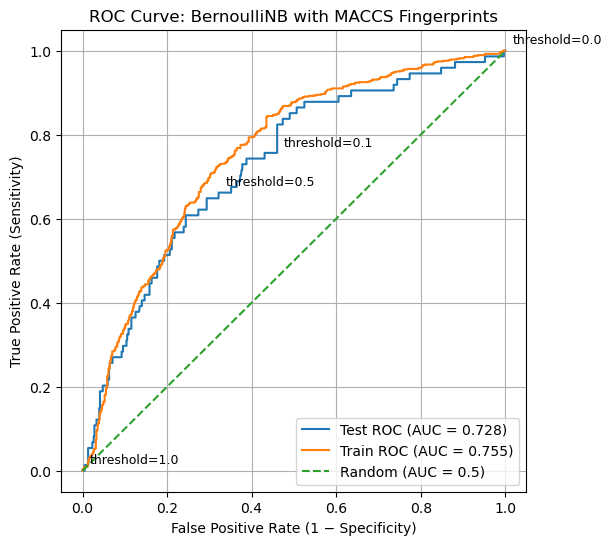

In [10]:
# 1. Imports
from pathlib import Path
import numpy as np

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    roc_auc_score,
    roc_curve
)

#2 Load arrays (uncomment if SPLIT_ROOT is not in memory)
SPLIT_ROOT = Path("data/AID743139/splits/90_10/arrays")

X_train = np.load(SPLIT_ROOT / "X_train.npy")
X_test  = np.load(SPLIT_ROOT / "X_test.npy")
y_train = np.load(SPLIT_ROOT / "y_train.npy")
y_test  = np.load(SPLIT_ROOT / "y_test.npy")

# 3. Balance the training set
idx_inactives = np.where(y_train == 0)[0]
idx_actives   = np.where(y_train == 1)[0]

num_actives = len(idx_actives)

np.random.seed(0)
idx_inactives_downsampled = np.random.choice(
    idx_inactives,
    size=num_actives,
    replace=False
)

X_train_bal = np.vstack((
    X_train[idx_inactives_downsampled],
    X_train[idx_actives]
))

y_train_bal = np.hstack((
    y_train[idx_inactives_downsampled],
    y_train[idx_actives]
))

print(X_train_bal.shape, y_train_bal.shape)

# 4 Fit model
clf = BernoulliNB()
clf.fit(X_train_bal, y_train_bal)

# 5. Scores
y_score_test  = clf.predict_proba(X_test)[:, 1]
y_score_train = clf.predict_proba(X_train_bal)[:, 1]

#6. Compute ROC-AUC (train and test)
auc_test  = roc_auc_score(y_test, y_score_test)
auc_train = roc_auc_score(y_train_bal, y_score_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_score_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_bal, y_score_train)

print("ROC curve arrays created:")
print("Test:", fpr_test.shape, tpr_test.shape, thresholds_test.shape)
print("Train:", fpr_train.shape, tpr_train.shape, thresholds_train.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Plot ROC curves
plt.plot(fpr_test,  tpr_test,  label=f"Test ROC (AUC = {auc_test:.3f})")
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})")

for t in [1.0, 0.5, 0.1, 0.0]:
    idx = np.argmin(np.abs(thresholds_test - t))
    plt.annotate(
        f"threshold={t}",
        (fpr_test[idx], tpr_test[idx]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=9
    )


# Reference line: random classifier
plt.plot([0, 1], [0, 1], linestyle='--', label="Random (AUC = 0.5)")

# Labels and title
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve: BernoulliNB with MACCS Fingerprints")

plt.legend(loc="lower right")
plt.grid(True)

plt.show()


The ROC curve provides a compact visual summary of how a classifier behaves as its decision threshold is varied. Each point on the curve represents a different trade-off between correctly identifying active compounds (true positives) and incorrectly flagging inactive compounds (false positives). A curve that rises steeply toward the upper-left corner indicates that the model identifies a large fraction of true actives while introducing relatively few false positives at early thresholds. This is the ideal behavior in many screening contexts, where missing active compounds is costly but excessive false positives are also undesirable. In contrast, a curve that closely follows the diagonal line from the bottom-left to the top-right indicates a model with little discriminatory power: true positives and false positives increase at similar rates, as would be expected from random guessing. 

<div class="alert alert-block alert-info">
<strong>Deeper Dive: How Thresholds Generate an ROC Curve</strong>

<p><strong>Discussion question:</strong><br>
If the decision threshold is just a single number, how can a single model produce an entire ROC curve?</p>

<div class="alert alert-block alert-success">
<details>
  <summary>Explanation</summary>

  <p>An ROC curve is generated by <em>systematically varying the decision threshold</em> applied to the model’s probability scores.</p>

  <p>Once a model is trained, each compound receives a fixed probability score (for example, <code>P(active)</code>). These scores can be sorted from highest to lowest, creating a ranked list of compounds.</p>

  <p>Starting with a very high threshold (so that no compounds are predicted active), the threshold is gradually lowered. Each time the threshold passes the score of a compound, that compound changes from predicted inactive to predicted active. This change updates the confusion matrix and produces a new pair of values:</p>

  <ul>
    <li><strong>True Positive Rate (TPR):</strong> fraction of true actives correctly identified</li>
    <li><strong>False Positive Rate (FPR):</strong> fraction of true inactives incorrectly flagged</li>
  </ul>

  <p>Each threshold that changes the predictions produces a single point on the ROC curve. Many numerical threshold values may produce the <em>same</em> confusion matrix if no compound scores fall between them, which is why threshold is best thought of as a <em>control parameter</em>, not an axis variable.</p>

  <p>The ROC curve therefore shows how the balance between true positives and false positives evolves as the decision threshold is swept from conservative to permissive.</p>

</details>
</div>
</div>


## 4.3 AUC: Summarizing ROC Behavior
The ROC curve provides a rich visual summary of how a classifier behaves as the decision threshold is varied. However, comparing ROC curves by eye can be difficult, especially when multiple models or datasets are involved. The Area Under the Curve (AUC) provides a way to condense the information contained in the ROC curve into a single number that summarizes overall model performance.

Geometrically, AUC is exactly what its name suggests: the area under the ROC curve, bounded by the axes. Because both the false positive rate and true positive rate range from 0 to 1, the maximum possible area is 1.0. A model whose ROC curve lies close to the upper-left corner of the plot will have a large area under the curve, while a model whose ROC curve follows the diagonal line of random guessing will have an area close to 0.5.

Importantly, AUC does not correspond to performance at any single decision threshold. Instead, it summarizes how the model behaves across all thresholds. Models with high AUC values tend to achieve high true positive rates while keeping false positive rates low over a wide range of thresholds. Models with AUC values near 0.5 show little ability to distinguish actives from inactives, regardless of how the threshold is chosen.

From a conceptual perspective, AUC can also be understood as a ranking metric. It represents the probability that a randomly chosen active compound receives a higher predicted score than a randomly chosen inactive compound. In this interpretation, AUC measures how well the model orders compounds by their likelihood of activity, independent of any particular cutoff or decision rule.

This ranking-based view explains why AUC is often described as threshold-independent. The threshold is still present implicitly, it is swept across all possible values when the ROC curve is constructed, but no single threshold is privileged. AUC therefore answers a different question than accuracy or sensitivity: does the model meaningfully separate actives from inactives at all?

AUC does not tell us which threshold to use, nor does it encode the costs of false positives and false negatives. Instead, it provides a diagnostic measure of whether the model contains useful discriminatory information. Once that information is established, threshold selection becomes a separate decision-making problem, guided by scientific goals, resource constraints, and tolerance for error.

<div class="alert alert-block alert-info">
<strong>Before Running the next code cell predict if the training set or the test set would have the higher AUC score</strong>

</div>


In [11]:
# Compute AUC for train and test sets

from sklearn.metrics import roc_auc_score

# AUC values
auc_train = roc_auc_score(y_train_bal, y_score_train)
auc_test  = roc_auc_score(y_test, y_score_test)

print("ROC–AUC Summary")
print("----------------")
print(f"Training AUC (balanced): {auc_train:.3f}")
print(f"Test AUC:               {auc_test:.3f}")
print("\nInterpretation guide:")
print("AUC ≈ 0.5 → no discrimination (random)")
print("AUC → 1.0 → strong separation of actives and inactives")


ROC–AUC Summary
----------------
Training AUC (balanced): 0.755
Test AUC:               0.728

Interpretation guide:
AUC ≈ 0.5 → no discrimination (random)
AUC → 1.0 → strong separation of actives and inactives


<div class="alert alert-block alert-info">
<strong>Looking Ahead: What Does AUC Actually Measure?</strong>

<p><strong>Discussion question:</strong><br>
Two classifiers produce ROC curves that start at (0, 0) and end at (1, 1), as all ROC curves must. One curve rises steeply toward the upper-left corner at low false positive rates, while the other remains closer to the diagonal for much of its length.</p>

<div class="alert alert-block alert-success">
<details>
  <summary>Explanation</summary>

  <p>The Area Under the ROC Curve (AUC) summarizes the model’s performance across <em>all possible decision thresholds</em> into a single number.</p>

  <p>Geometrically, AUC is the total area beneath the ROC curve. Intuitively, it reflects how quickly the curve rises toward the upper-left corner, where true positives are maximized while false positives remain low.</p>

  <p>From a ranking perspective, AUC can be interpreted as the probability that a randomly chosen active compound receives a higher score than a randomly chosen inactive compound.</p>

  <p>AUC does <em>not</em> select a threshold or define a decision rule. Instead, it answers a different question: <em>Does the model meaningfully separate actives from inactives at all?</em> Threshold selection comes later, once this overall separation has been established.</p>

</details>
</div>
</div>


The ROC curves for both the training and test sets lie well above the diagonal reference line, indicating that the model has learned a meaningful ranking signal rather than behaving like a random classifier. The training curve consistently exceeds the test curve, as expected, but the gap between them is modest, suggesting limited overfitting and reasonable generalization. The test-set AUC of approximately 0.72 confirms that active compounds tend to receive higher scores than inactive compounds, even though no single decision threshold has yet been chosen. At the same time, the gradual rise of the curve highlights an inherent trade-off: increasing sensitivity necessarily increases the false positive rate. This reinforces the idea that ROC–AUC evaluates whether useful separation exists at all, while the choice of a specific threshold must be guided by scientific or practical priorities.

# 5. Choosing an Operating Threshold (Decision Engineering)
What principle should we use to choose the optimal theshold to generate the confusion matrix?


Test confusion matrix:
 [[400 206]
 [ 25  49]]

Training confusion matrix:
 [[457 212]
 [187 482]]


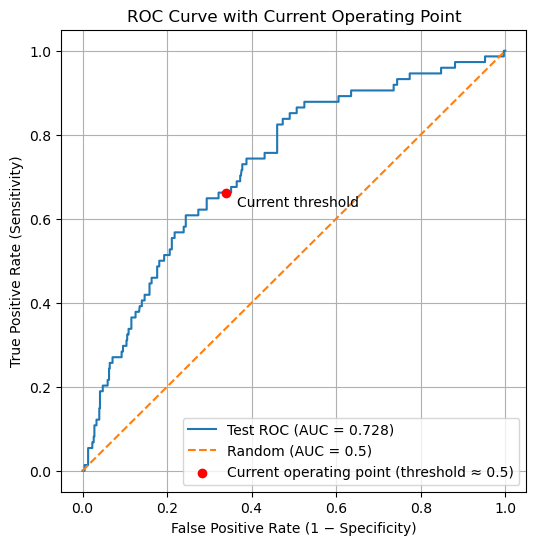

Current operating point (default threshold ~0.5):
False Positive Rate (FPR) = 0.3399
True Positive Rate (TPR)  = 0.6622


In [12]:
from sklearn.metrics import confusion_matrix

# Run code in section 4 to reload and fit the model
#5 Predict Hard Labels
y_pred_test  = clf.predict(X_test)
y_pred_train = clf.predict(X_train_bal)

# Create confusion matrices (train and test)

cm_test  = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train_bal, y_pred_train)

TN, FP, FN, TP = cm_test.ravel()
TN_tr, FP_tr, FN_tr, TP_tr = cm_train.ravel()

print("Test confusion matrix:\n", cm_test)
print("\nTraining confusion matrix:\n", cm_train)
FPR_current = FP / (FP + TN)
TPR_current = TP / (TP + FN)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Plot test ROC curve
plt.plot(
    fpr_test,
    tpr_test,
    label=f"Test ROC (AUC = {auc_test:.3f})"
)

# Plot random baseline
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    label="Random (AUC = 0.5)"
)

# Mark current operating point
plt.scatter(
    FPR_current,
    TPR_current,
    color="red",
    zorder=5,
    label="Current operating point (threshold ≈ 0.5)"
)

# Annotate the point
plt.annotate(
    "Current threshold",
    (FPR_current, TPR_current),
    textcoords="offset points",
    xytext=(8, -10)
)

# Labels and title
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve with Current Operating Point")

plt.legend(loc="lower right")
plt.grid(True)

plt.show()

# --- Current operating point from test confusion matrix ---

FPR_current = FP / (FP + TN)
TPR_current = TP / (TP + FN)

print("Current operating point (default threshold ~0.5):")
print(f"False Positive Rate (FPR) = {FPR_current:.4f}")
print(f"True Positive Rate (TPR)  = {TPR_current:.4f}")


## 5.1 Locating the Current Operating Point
The red point shown on the ROC curve represents the current operating point of the classifier, produced by the default decision rule used by .predict() (approximately a probability threshold of 0.5). This point is computed directly from the confusion matrix, not from the ROC curve itself.

Importantly, this operating point is not guaranteed to correspond exactly to a point on the ROC curve. The ROC curve is constructed by sweeping through data-derived probability thresholds, whereas the default threshold is a fixed parameter of the classifier. As a result, the default threshold usually falls between two ROC thresholds rather than exactly on one.

To relate the default classifier to the ROC curve, we therefore identify the nearest ROC point in (FPR, TPR) space. This allows us to locate where the default decision rule lies relative to all possible threshold choices, even though it is not itself a ROC threshold. This distinction matters because choosing an operating threshold is a decision problem, not a plotting artifact. The ROC curve shows what is possible; selecting a threshold determines what the model actually does. We now turn to principled ways of making that choice.

In [13]:
# Compute distance between current operating point and each ROC point
distances = np.sqrt(
    (fpr_test - FPR_current)**2 +
    (tpr_test - TPR_current)**2
)

idx = np.argmin(distances)

print("Closest ROC point index:", idx)
print(f"Threshold at this point = {thresholds_test[idx]:.4f}")
print(f"FPR at this point       = {fpr_test[idx]:.4f}")
print(f"TPR at this point       = {tpr_test[idx]:.4f}")


Closest ROC point index: 74
Threshold at this point = 0.4585
FPR at this point       = 0.3515
TPR at this point       = 0.6622


Note: The decision threshold is not associated with either ROC axis. It is a model parameter, not a plotted variable. The default threshold (≈ 0.5) produces an operating point at FPR = 0.3399 and TPR = 0.6622, but this point is not itself a ROC data point. It lies between ROC thresholds derived from the model’s predicted probabilities.
## 5.2 Choosing an Operating Threshold: Youden's J statistic
What principle should we use to choose the optimal theshold to generate the confusion matrix?

At what threshold is a model simultaneously good at finding actives and rejecting inactives? One answer is given by Youden’s J statistic, which identifies the point on the ROC curve that is farthest vertically from the diagonal (random classification):
$$ J = TPR-FPR $$
 * J=0  random performance
 * J=1 perfect classification
 * At each threshold, J is the vertical distance between the ROC curve and the diagonal
 * Maximizing J is equivalent to maximizing TPR relative to FPR

Other threshold-selection criteria exist, including distance-based, cost-based, and policy-driven approaches. In practice, threshold selection is a form of decision engineering, not model evaluation.

From this point forward, we explicitly distinguish between confusion matrices computed at different decision thresholds. When comparing thresholds, each operating point must be evaluated using its own confusion matrix, and variables are named to reflect the decision rule used to generate them

In [14]:
# 10 Youden's J – choose threshold (training set)

youden_J_train = tpr_train - fpr_train
idx_J = np.argmax(youden_J_train)

youden_threshold = thresholds_train[idx_J]

print("Youden-optimal threshold (from training data):")
print(f"Threshold = {youden_threshold:.4f}")
print(f"TPR       = {tpr_train[idx_J]:.4f}")
print(f"FPR       = {fpr_train[idx_J]:.4f}")
print(f"Youden J  = {youden_J_train[idx_J]:.4f}")


Youden-optimal threshold (from training data):
Threshold = 0.0908
TPR       = 0.8430
FPR       = 0.4350
Youden J  = 0.4081


Because threshold selection is a tuning step, we determine the Youden-optimal threshold using the training data and then apply it to the test set for evaluation.

In [15]:
# 11 Apply Youden's threshold (new predictions)
y_test_pred_youden  = (y_score_test  >= youden_threshold).astype(int)
y_pred_train_youden = (y_score_train >= youden_threshold).astype(int)

# 12. Confusion matrices (youden-optimal)
cm_test_youden  = confusion_matrix(y_test, y_test_pred_youden)
cm_train_youden = confusion_matrix(y_train_bal, y_pred_train_youden)

TN_y, FP_y, FN_y, TP_y = cm_test_youden.ravel()
TN_tr_y, FP_tr_y, FN_tr_y, TP_tr_y = cm_train_youden.ravel()

print("Test confusion matrix:\n", cm_test)
print("Test confusion matrix (Youden-optimal):\n", cm_test_youden)
print("\nTraining confusion matrix:\n", cm_train)
print("\nTraining confusion matrix (Youden-optimal):\n", cm_train_youden)


Test confusion matrix:
 [[400 206]
 [ 25  49]]
Test confusion matrix (Youden-optimal):
 [[325 281]
 [ 13  61]]

Training confusion matrix:
 [[457 212]
 [187 482]]

Training confusion matrix (Youden-optimal):
 [[378 291]
 [105 564]]


The confusion matrices below show the impact of replacing the default decision threshold with the Youden-optimal threshold learned from the training data.

At the default threshold, the classifier is relatively conservative: it produces fewer false positives but also misses a substantial number of actives. When the threshold is shifted to the Youden-optimal value, the classifier becomes more permissive, reflecting an explicit trade-off between sensitivity and specificity.

On the test set, applying the Youden-optimal threshold:

Increases true positives (49 → 61), improving the model’s ability to identify actives

Decreases false negatives (25 → 13), reducing missed actives

Increases false positives (206 → 281), accepting more inactives as a consequence

In [16]:
#  Predict probability scores
y_score_test  = clf.predict_proba(X_test)[:, 1]
y_score_train = clf.predict_proba(X_train_bal)[:, 1]

# 9. ROC curve and AUC (test set)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)

print(f"Test ROC–AUC = {auc_test:.4f}")


Test ROC–AUC = 0.7279


Default operating point:
FPR = 0.3399, TPR = 0.6622

Youden-optimal operating point:
FPR = 0.4637, TPR = 0.8243


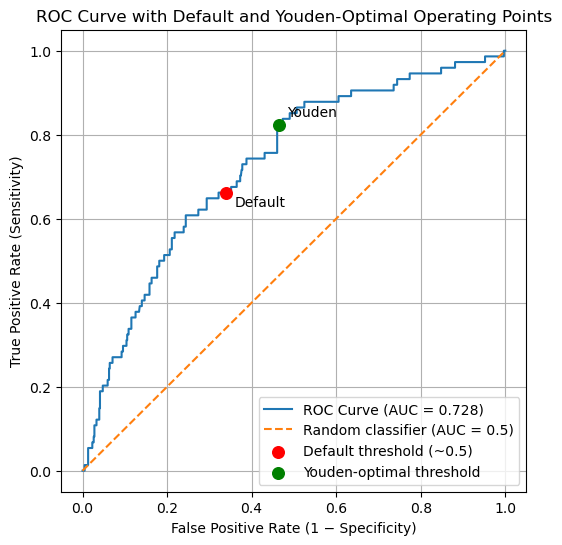

In [17]:
#### Compare Default and Youden values
# Compute operating point for default threshold
cm_default = confusion_matrix(y_test, y_pred_test)
TN_d, FP_d, FN_d, TP_d = cm_default.ravel()

FPR_default = FP_d / (FP_d + TN_d)
TPR_default = TP_d / (TP_d + FN_d)

# Compute operating point for Youden-optimal threshold
cm_youden = confusion_matrix(y_test, y_test_pred_youden)
TN_y, FP_y, FN_y, TP_y = cm_youden.ravel()

FPR_youden = FP_y / (FP_y + TN_y)
TPR_youden = TP_y / (TP_y + FN_y)

print("Default operating point:")
print(f"FPR = {FPR_default:.4f}, TPR = {TPR_default:.4f}")

print("\nYouden-optimal operating point:")
print(f"FPR = {FPR_youden:.4f}, TPR = {TPR_youden:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# ROC curve
plt.plot(
    fpr_test,
    tpr_test,
    label=f"ROC Curve (AUC = {auc_test:.3f})"
)

# Random classifier reference
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    label="Random classifier (AUC = 0.5)"
)

# Default threshold operating point
plt.scatter(
    FPR_default,
    TPR_default,
    color="red",
    s=70,
    zorder=5,
    label="Default threshold (~0.5)"
)

# Youden-optimal operating point
plt.scatter(
    FPR_youden,
    TPR_youden,
    color="green",
    s=70,
    zorder=5,
    label="Youden-optimal threshold"
)

# Annotate points
plt.annotate(
    "Default",
    (FPR_default, TPR_default),
    textcoords="offset points",
    xytext=(6, -10)
)

plt.annotate(
    "Youden",
    (FPR_youden, TPR_youden),
    textcoords="offset points",
    xytext=(6, 6)
)

# Labels and title
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve with Default and Youden-Optimal Operating Points")

plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import accuracy_score

# ---------- Default threshold metrics ----------
acc_d  = accuracy_score(y_test, y_pred_test)
prec_d = TP_d / (TP_d + FP_d) if (TP_d + FP_d) else 0.0
sens_d = TP_d / (TP_d + FN_d) if (TP_d + FN_d) else 0.0
spec_d = TN_d / (TN_d + FP_d) if (TN_d + FP_d) else 0.0
bacc_d = (sens_d + spec_d) / 2
f1_d   = (2 * prec_d * sens_d / (prec_d + sens_d)) if (prec_d + sens_d) else 0.0

# ---------- Youden-optimal metrics ----------
acc_y  = accuracy_score(y_test, y_test_pred_youden)
prec_y = TP_y / (TP_y + FP_y) if (TP_y + FP_y) else 0.0
sens_y = TP_y / (TP_y + FN_y) if (TP_y + FN_y) else 0.0
spec_y = TN_y / (TN_y + FP_y) if (TN_y + FP_y) else 0.0
bacc_y = (sens_y + spec_y) / 2
f1_y   = (2 * prec_y * sens_y / (prec_y + sens_y)) if (prec_y + sens_y) else 0.0

print("TEST SET PERFORMANCE COMPARISON\n")

print("Default threshold (~0.5)")
print(f"Accuracy          = {acc_d:.4f}")
print(f"Precision         = {prec_d:.4f}")
print(f"Sensitivity       = {sens_d:.4f}")
print(f"Specificity       = {spec_d:.4f}")
print(f"Balanced Accuracy = {bacc_d:.4f}")
print(f"F1 Score          = {f1_d:.4f}\n")

print("Youden-optimal threshold")
print(f"Accuracy          = {acc_y:.4f}")
print(f"Precision         = {prec_y:.4f}")
print(f"Sensitivity       = {sens_y:.4f}")
print(f"Specificity       = {spec_y:.4f}")
print(f"Balanced Accuracy = {bacc_y:.4f}")
print(f"F1 Score          = {f1_y:.4f}")


TEST SET PERFORMANCE COMPARISON

Default threshold (~0.5)
Accuracy          = 0.6603
Precision         = 0.1922
Sensitivity       = 0.6622
Specificity       = 0.6601
Balanced Accuracy = 0.6611
F1 Score          = 0.2979

Youden-optimal threshold
Accuracy          = 0.5676
Precision         = 0.1784
Sensitivity       = 0.8243
Specificity       = 0.5363
Balanced Accuracy = 0.6803
F1 Score          = 0.2933


The ROC curve summarizes all possible operating points for the classifier. The default and Youden-optimal thresholds correspond to specific locations on this curve, illustrating how threshold selection shifts the balance between sensitivity and specificity without changing the underlying model.

| Metric                   | Default Threshold | Youden-Optimal Threshold | Interpretation                                                                                                                                                                 |
| ------------------------ | ----------------- | ------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Accuracy**             | **0.6603**        | 0.5676                   | Accuracy decreases at the Youden-optimal threshold because more inactive compounds are intentionally classified as active. In imbalanced datasets, accuracy can be misleading. |
| **Precision**            | **0.1922**        | 0.1784                   | Precision decreases slightly as sensitivity increases. This reflects the cost of accepting more false positives to capture additional actives.                                 |
| **Sensitivity (Recall)** | 0.6622            | **0.8243**               | Sensitivity increases substantially at the Youden-optimal threshold, indicating that fewer active compounds are missed.                                                        |
| **Specificity**          | **0.6601**        | 0.5363                   | Specificity decreases, as more inactive compounds are incorrectly classified as active.                                                                                        |
| **Balanced Accuracy**    | 0.6611            | **0.6803**               | Balanced accuracy improves, showing better overall separation between actives and inactives when class imbalance is taken into account.                                        |
| **F1 Score**             | **0.2979**        | 0.2933                   | The F1 score remains similar, illustrating that improvements in recall are largely offset by reduced precision.                                                                |
                               |
Changing the decision threshold does not improve all metrics simultaneously. The Youden-optimal threshold favors finding actives, even at the cost of more false positives. This trade-off may be desirable in screening applications but must be evaluated in the context of experimental goals and resource constraints.

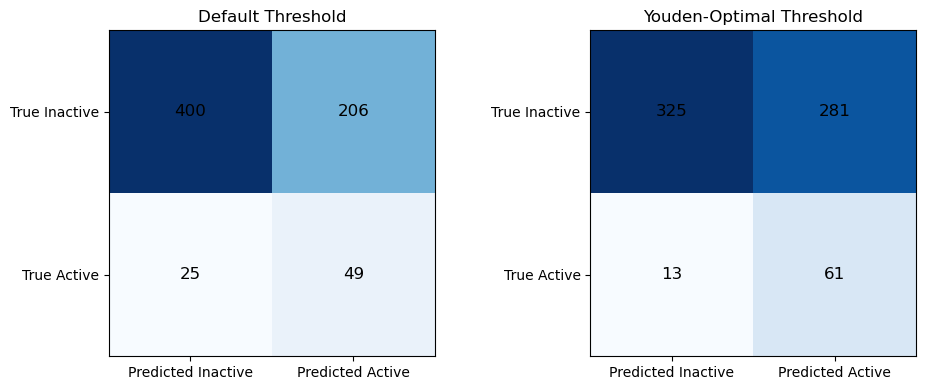

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

cm_default = np.array([[TN_d, FP_d],
                       [FN_d, TP_d]])

cm_youden = np.array([[TN_y, FP_y],
                      [FN_y, TP_y]])

titles = ["Default Threshold", "Youden-Optimal Threshold"]

for ax, cm, title in zip(axes, [cm_default, cm_youden], titles):
    im = ax.imshow(cm, cmap="Blues")

    # Annotate cells with counts
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="black", fontsize=12)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Predicted Inactive", "Predicted Active"])
    ax.set_yticklabels(["True Inactive", "True Active"])
    ax.set_title(title)

plt.tight_layout()
plt.show()



The two confusion matrices illustrate how changing the decision threshold alters the classifier’s operating behavior without changing the underlying model. At the default threshold, the classifier is more conservative: it correctly identifies 400 inactive compounds and 49 active compounds, but misses 25 actives and incorrectly labels 206 inactives as active. When the Youden-optimal threshold is applied, the classifier becomes more permissive. The number of correctly identified actives increases (49 → 61), and missed actives decrease substantially (25 → 13), indicating improved sensitivity. However, this gain comes at the cost of reduced specificity: more inactive compounds are incorrectly classified as active (206 → 281), and fewer inactives are correctly rejected (400 → 325). This comparison makes explicit the trade off introduced by threshold selection, improving the ability to find actives necessarily increases false positives, and reinforces that different thresholds correspond to different operational priorities rather than “better” or “worse” models.

**Comparing Training and Test Performance at the Youden-Optimal Threshold**

Evaluating the classifier at the Youden-optimal threshold highlights how model performance depends not only on the learned representation, but also on the decision rule used to translate probabilities into classifications. At this operating point, balanced accuracy improves relative to the default threshold on the test set (0.680 vs. 0.661), indicating better overall separation between active and inactive compounds when class imbalance is taken into account. This improvement is driven by a substantial increase in sensitivity, with more active compounds correctly identified, accompanied by a corresponding decrease in specificity as additional inactives are accepted.

Comparing training and test behavior at the Youden-optimal threshold shows that this trade-off is preserved across datasets: in both cases, sensitivity increases while specificity decreases relative to the default operating point. This consistency suggests that the model’s underlying ranking of compounds generalizes reasonably well to unseen data, even though individual performance metrics shift with dataset composition.

Importantly, metrics such as accuracy, precision, and F1 score change in different, and sometimes counterintuitive, ways as the threshold is adjusted. Precision in particular remains low on the test set due to extreme class imbalance, despite improvements in sensitivity and balanced accuracy. This reinforces a central lesson of this module: no single metric fully captures model performance, and threshold selection reflects experimental priorities rather than an objective notion of correctness.

Taken together, these results emphasize that model evaluation does not end with training. A trained classifier defines a continuum of possible operating behaviors, and selecting a threshold is a form of decision engineering that must be guided by the goals, constraints, and costs of the scientific application

Comparing confusion matrices at different thresholds shows that threshold selection controls the balance of false positives and false negatives without altering the learned model, making ROC-guided decisions an essential step in supervised learning.

# 6. Homework
In section 3.2 Recover CIDs of compounds you created a dataframe (df_test_proba) that contained 680 PubChem CIDs and their predicted activities.  You will use that dataset as the starting point for this assignment.

## Part 1: Threshold Exploration
Create a Pandas DataFrame with   
- Pubchem CID
- y_true (actual active/inactive value)
- p_active from .predict_proba() - the probablity score ranking

Populate this data frame with 30 compounds roughly evenly spaced
```python
df_sorted = df.sort_values("p_active").reset_index(drop=True)
indices = np.linspace(0, len(df_sorted) - 1, 30, dtype=int)
df_even30 = df_sorted.iloc[indices].reset_index(drop=True)
```
1. Add Threshold colums for the following values (0.0, 0.33, 0.67 and 1.0) 
2. In each column use the threshold to indicate of a chemical is active or inactive.
>The following code creates a boolean value for each threshold and then converts it to an integer

```python
#thresholds = [0.0, 0.33, 0.67, 1.0]

pred_col = "pred_t0.33"

TN = ((df_even30[pred_col] == 0) & (df_even30["y_true"] == 0)).sum()
FP = ((df_even30[pred_col] == 1) & (df_even30["y_true"] == 0)).sum()
FN = ((df_even30[pred_col] == 0) & (df_even30["y_true"] == 1)).sum()
TP = ((df_even30[pred_col] == 1) & (df_even30["y_true"] == 1)).sum()

cm = [[TN, FP],
      [FN, TP]]
)
```  

Using your dataframe create a confusion matrix for the 4 thresholds (two are trivial). That is:

   -count TN, FN, TP and FP, and arrange them into a matrix using matplotlib or seaborn

    
## Part 2: Analysis of Top Predictions   
The goal here is to look for similarity of the top 30 compounds and see if there is a chemical correlation to activity.
```python
df_top30 = (
    df
    .sort_values(by="p_active", ascending=False)
    .head(30)
    .reset_index(drop=True)
)
```
Using this subset of compounds, carry out the following steps:

1. Convert the PubChem CIDs to RDKit molecule objects and display the molecular structures.
2. Using the chosen decision threshold, identify each compound as a true positive (TP) or false positive (FP).
3. Reorder the DataFrame so that all true positives appear first, followed by all false positives.
4. Regenerate MACCS fingerprints for these compounds as RDKit explicit bit vectors.
5. Compute pairwise Tanimoto similarity scores between all compounds.
6. Visualize the resulting similarity matrix as a heat map, ordered with true positives first and false positives last.  
Note: The similarity matrix will be symmetric, and the diagonal elements will always have a value of 1.0.
